In [568]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src/data')

from get_users_info import *
from get_brand_category_info import *
from get_preference_matrix import *
import implicit
import faiss
from tqdm import tqdm
from scipy.sparse import csr_matrix
from scipy.spatial.distance import euclidean, cosine
from sklearn.metrics import precision_score
from itertools import islice


In [69]:
import warnings
warnings.filterwarnings("ignore")

In [290]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [3]:
# матрица предпочтений
pref_matrix = get_pref_matrix(to_csv=False)
item_user = pref_matrix.drop(columns=['id_s','item_total'], index = ['user_total'])

/var/folders/k_/q2nqvc5s4b9g7bf4ljty8wd00000gn/T/ipykernel_21480/475309608.py:2: DtypeWarning: Columns (7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  pref_matrix = get_pref_matrix(to_csv=False)
../src/data/get_preference_matrix.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products['ym_client_id'] = products['ym_client_id'].astype(str)


In [ ]:
users_info = get_users_info(to_csv=False)

In [4]:
def count_active_users(item_user = item_user, users_info = users_info, thresholds = 50):
    'считает число пользователей с заданным числом активностей по просмотрам, корзинам, вишлистам'
    users = []
    for threshold in range(thresholds):
        users_info_cut = users_info.loc[(users_info.products_quan + 
                                         users_info.carts_quan + 
                                         users_info.wish_quan) > threshold]

        user_item = item_user.T
        user_item_cut = user_item.loc[user_item.index.isin(users_info_cut.index)]

        users.append(user_item_cut.shape[0])

    return pd.DataFrame(users)

NameError: name 'users_info' is not defined

In [33]:
count_active_users(thresholds=20)
## можно еще посчитать среднее время, за которое пользователь доходит до каждого порога

,0
0,35789
1,18887
2,7993
3,5636
4,4285
5,3451
6,2833
7,2395
8,2061
9,1799


In [11]:
threshold = 3
def cut_user_item(item_user, threshold = 3):
    user_item = item_user.T
    user_item_bin = (user_item > 0).astype(int)
    user_item_bin = user_item_bin.loc[user_item_bin.sum(axis = 1)>threshold]

    user_item_cut = user_item.loc[user_item.index.isin(user_item_bin.index)]
    item_user_cut = user_item_cut.T

    return user_item_cut

In [7]:
# нормализуем строки матрицы юзер-айтем
user_item_cut_normalized = user_item_cut.div(user_item_cut.sum(axis = 1), axis = 0)

In [569]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [592]:
def recommend_NN(user_item_cut, user_item_cut_index, metric = 'euclid', k = 10, method ='faiss'):
    'берет на вход датафрейм с накликавшими пользователями (cf-able), каждому из них ищет k соседей\
     на основе metric и выдает рекоммендации, user_..index определяет пользователей для генерации рекомендаций'
        # создаю индекс длиной числа брендов-категорий
        # добавляю туда все вектора по юзерам
    user_item_cut_normalized = user_item_cut.div(user_item_cut.sum(axis = 1), axis = 0)
    
    if method == 'faiss':
        
        if metric == 'euclid':
            index = faiss.IndexFlatL2(user_item_cut.shape[1],)
            user_item_array = np.array(user_item_cut).astype('float32')
            if str(user_item_array.flags)[17:22] == 'False':
                user_item_array = user_item_array.copy(order='C')
            index.add(user_item_array)
        elif metric == 'cosine':
            index = faiss.IndexFlatIP(user_item_cut.shape[1],)
            user_item_array = np.array(user_item_cut_normalized).astype('float32')
            if str(user_item_array.flags)[17:22] == 'False':
                user_item_array = user_item_array.copy(order='C')
            index.add(user_item_array)


        user_dict = {}
        # создаю юзера, для которого будут искаться соседи
        for searched_user_clid in user_item_cut_index:
            searched_user_index = user_item_cut.index.get_loc(searched_user_clid)
            searched_user = user_item_array[searched_user_index]
            # меняю формат вектора, чтобы подходил для метода поиска
            searched_user = searched_user.reshape((1,searched_user.shape[0]))
            # нахожу k соседей для выбранного юзера
            dist, ind = index.search(searched_user, k = k)
            # оставляю только соседей
            ind_reshape = ind.reshape((k,))
    #         ind_reshape = ind_reshape[ind_reshape != searched_user_index]

            # нахожу соседей в юзер-айтем матрице, оставляю только столбы с ненулевыми элементами
            found_neighbours = user_item_cut.iloc[ind_reshape,:]
            if metric == 'cosine':
                found_neighbours.loc[searched_user_clid] = user_item_cut.loc[searched_user_clid]

            found_neighbours.loc['preferred_bin'] = (found_neighbours.loc[searched_user_clid]>0).astype(int)
            found_neighbours.loc['preferred_exact'] = found_neighbours.loc[searched_user_clid]
            found_neighbours.loc['recommended_bin'] = (found_neighbours.mean(axis = 0)>0).astype(int)
            found_neighbours.drop(index = [searched_user_clid], inplace = True)
            found_neighbours.loc['recommended'] = found_neighbours.drop(index = ['recommended_bin',
                                                                                 'preferred_bin', 
                                                                                 'preferred_exact']).mean(axis = 0)

            # found_neighbours = found_neighbours.T
            # found_neighbours[found_neighbours.loc[:,'recommended_bin'] > 0].T
            user_dict[searched_user_clid] = {}
            user_dict[searched_user_clid]['neighbours'] = found_neighbours.iloc[:k,:]
            user_dict[searched_user_clid]['recommends'] = found_neighbours.loc['recommended']
            user_dict[searched_user_clid]['recommends_binary'] = found_neighbours.loc['recommended_bin']
            user_dict[searched_user_clid]['preferred_binary'] = found_neighbours.loc['preferred_bin']
            user_dict[searched_user_clid]['preferred_exact'] = found_neighbours.loc['preferred_exact']
            
    if method == 'hardcode':
        
        user_dict = {}
        for user_ in user_item_diff.index:
        # user_ = '1586517765142996502'
            user_prefs = user_item_cut.loc[user_]
            non_null_prefs = user_item_cut.loc[:,user_prefs.loc[user_prefs!=0].index]
            nn = {}
            for user in non_null_prefs.index:
                if user != user_:
                    if metric == 'euclid':
                        distance = euclidean(user_prefs.loc[user_prefs!=0], non_null_prefs.loc[user])
                    if metric == 'cosine':
                        distance = cosine(user_prefs.loc[user_prefs!=0], non_null_prefs.loc[user])
                    nn[user] = distance

            found_neighbours = user_item_cut.loc[take(k,{k: v for k, v in sorted(nn.items(), key=lambda item: item[1])})]
            recommends = found_neighbours.mean(axis = 0)
            user_dict[user_] = {}
            user_dict[user_]['recommends'] = recommends
            user_dict[user_]['preferred_binary'] = user_item_cut.loc[user_]
    return user_dict

In [589]:
# хардкодим поиск ближ соседей по заполненным колонкам
user_dict = {}
for user_ in user_item_diff.index:
# user_ = '1586517765142996502'
    user_prefs = user_item_cut.loc[user_]
    non_null_prefs = user_item_cut.loc[:,user_prefs.loc[user_prefs!=0].index]
    nn = {}
    for user in non_null_prefs.index:
        if user != user_:
            if metric == 'euclid':
                distance = euclidean(user_prefs.loc[user_prefs!=0], non_null_prefs.loc[user])
            if metric == 'cosine':
                distance = cosine(user_prefs.loc[user_prefs!=0], non_null_prefs.loc[user])
            nn[user] = distance

    found_neighbours = user_item_cut.loc[take(10,{k: v for k, v in sorted(nn.items(), key=lambda item: item[1])})]
    recommends = found_neighbours.mean(axis = 0)
    user_dict[user_] = {}
    user_dict[user_]['recommends'] = recommends
    user_dict[user_]['preferred_binary'] = user_item_cut.loc[user_]

100%|███████████████████████████████████████████| 98/98 [00:41<00:00,  2.34it/s]


In [9]:
# подгружаем старую юзер-айтем
user_item_old = get_pref_matrix(to_csv=False, days_back=7).T

/var/folders/k_/q2nqvc5s4b9g7bf4ljty8wd00000gn/T/ipykernel_21480/2523952074.py:2: DtypeWarning: Columns (7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  user_item_old = get_pref_matrix(to_csv=False, days_back=7)
../src/data/get_preference_matrix.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products['ym_client_id'] = products['ym_client_id'].astype(str)


1586517765142996502  \
(1017 ALYX 9SM, Футболки и лонгсливы)                              0.0   
(10sei0otto, Джемперы и свитеры)                                   0.0   
(11 By Boris Bidjan Saberi, Футболки и лонгсливы)                  0.0   
(11 By Boris Bidjan Saberi, Штаны и брюки)                         0.0   
(424 On Fairfax, Куртки и пуховики)                                0.0   
...                                                                ...   
(Ziggy Chen, Пиджаки и жилеты)                                     0.0   
(Ziggy Chen, Штаны и брюки)                                        0.0   
(kaval, Штаны и брюки)                                             0.0   
(ВЛАД ВЫСОЦКИЙ, Украшения и другое)                                0.0   
user_total                                                        57.0   

                                                   1586839436824718143  \
(1017 ALYX 9SM, Футболки и лонгсливы)                              0.0   
(10sei0otto, Джемперы и свитеры)                                   0.0   
(11 By Boris Bidjan Saberi, Футболки и лонгсливы)                  0.0   
(11 By Boris Bidjan Saberi, Штаны и брюки)                         0.0   
(424 On Fairfax, Куртки и пуховики)                                0.0   
...                                                                ...   
(Ziggy Chen, Пиджаки и жилеты)                                     0.0   
(Ziggy Chen, Штаны и брюки)                                        0.0   
(kaval, Штаны и брюки)                                             0.0   
(ВЛАД ВЫСОЦКИЙ, Украшения и другое)                                0.0   
user_total                                                         3.0   

                                                   1586861088574635654  \
(1017 ALYX 9SM, Футболки и лонгсливы)                              0.0   
(10sei0otto, Джемперы и свитеры)                                   0.0   
(11 By Boris Bidjan Saberi, Футболки и лонгсливы)                  0.0   
(11 By Boris Bidjan Saberi, Штаны и брюки)                         0.0   
(424 On Fairfax, Куртки и пуховики)                                0.0   
...                                                                ...   
(Ziggy Chen, Пиджаки и жилеты)                                     0.0   
(Ziggy Chen, Штаны и брюки)                                        0.0   
(kaval, Штаны и брюки)                                             0.0   
(ВЛАД ВЫСОЦКИЙ, Украшения и другое)                                0.0   
user_total                                                         2.0   

                                                   1586877094630823534  \
(1017 ALYX 9SM, Футболки и лонгсливы)                              0.0   
(10sei0otto, Джемперы и свитеры)                                   0.0   
(11 By Boris Bidjan Saberi, Футболки и лонгсливы)                  0.0   
(11 By Boris Bidjan Saberi, Штаны и брюки)                         0.0   
(424 On Fairfax, Куртки и пуховики)                                0.0   
...                                                                ...   
(Ziggy Chen, Пиджаки и жилеты)                                     0.0   
(Ziggy Chen, Штаны и брюки)                                        0.0   
(kaval, Штаны и брюки)                                             0.0   
(ВЛАД ВЫСОЦКИЙ, Украшения и другое)                                0.0   
user_total                                                         5.0   

                                                   1587480513689496288  \
(1017 ALYX 9SM, Футболки и лонгсливы)                              0.0   
(10sei0otto, Джемперы и свитеры)                                   0.0   
(11 By Boris Bidjan Saberi, Футболки и лонгсливы)                  0.0   
(11 By Boris Bidjan Saberi, Штаны и брюки)                         0.0   
(424 On Fairfax, Куртки и пуховики)                                0.0   
...                                                

In [15]:
# user_item_old = user_item_old.T
user_item_old = user_item_old.drop(columns=['id_s','item_total'], index = ['user_total'])
user_item_old_cut = cut_user_item(item_user=user_item_old)

In [22]:
matching_users = set(user_item_cut.index).intersection(set(user_item_old_cut.index))
len(matching_users)

2307

In [32]:
user_item_old_cut = user_item_old_cut.reindex(columns=user_item_cut.columns, fill_value=0)

In [296]:
# трейн выборка для первой метрики: те, у кого разность между бинаризованными векторами предпочтений ненулевая
user_item_diff = pd.DataFrame(columns=user_item_cut.columns)
users_with_new_prefs = []
for user in user_item_old_cut.index:
    #тут сначала бинаризовать а потом вычитать только!!!!!!!
    new_prefs = (user_item_cut.loc[user]>0).astype(int) - (user_item_old_cut.loc[user]>0).astype(int)
    if new_prefs.sum() > 0:
        users_with_new_prefs.append(user)
        user_item_diff = user_item_diff.append(new_prefs)
        
user_item_diff
# new_prefs

(98, 576)

In [ ]:
# доделать эту метрику
# сделать доп метрику по расстоянию и тоже зафиттиться
# попробовать несколько раз наоценивать с шагом в неделю-две
# распихать все по функциям аккуратненько

In [536]:
def precision_at_k(user_item_diff, user_dict, k):
    "считает для таргет матрицы и столбцов предиктов метрику precision at k"
    user_acc = {}
    for user in user_item_diff.index:
        target_bin = user_item_diff.loc[user]
        predict_exact = user_dict[user]['recommends']

        compared = pd.DataFrame([target_bin, 
                                 user_dict[user]['preferred_binary'],
                                 predict_exact], index = ['fut','prev','predict_exact']).T
        compared.loc[:,'predict_exact_new'] = np.where(compared.prev == 0, compared.predict_exact, 0)

        y_true = compared.sort_values('predict_exact_new',ascending = False).iloc[:k,:]['fut']
        y_pred = np.where(compared.sort_values('predict_exact_new',ascending = False).iloc[:k,:]['predict_exact_new'] >0,1,0)
        acc = precision_score(y_true, y_pred)
        user_acc[user] = {}
        user_acc[user]['accuracy'] = acc
    mean_acc = np.mean([user_acc[user]['accuracy'] for user in user_acc])
    max_acc = max([user_acc[user]['accuracy'] for user in user_acc])
    return mean_acc, max_acc

In [539]:
a = precision_at_k(user_item_diff, user_dict, 30), precision_at_k(user_item_diff, user_dict, 10)
[i for sub in a for i in sub]

[0.03707482993197279, 0.6333333333333333, 0.045918367346938764, 0.8]

In [458]:
def get_accuracy(user_item_diff, user_dict, metric = 'euclid'):
    "подсчитывает процент попаданий предсказанных айтемов в фактически новые просмотренные айтемы \
    user_item_diff - дф с новыми просмотрами людей, user_dict хранит рекомендации"
    user_acc = {}
    for user in user_item_diff.index:
        target_bin = user_item_diff.loc[user]
        target_exact = user_dict[user]['preferred_exact']
        predict_bin = user_dict[user]['recommends_binary'] 
        predict_exact = user_dict[user]['recommends']
        
        # попали, если число нулей в разности увеличилось
        compared = pd.DataFrame([predict_bin,
                                 target_bin, 
                                 user_dict[user]['preferred_binary'],
                                 target_exact, 
                                 predict_exact], index = ['predict','fut','prev','target_exact','predict_exact']).T
        compared.loc[:,'pred_only'] = (compared.predict - compared.prev).map(lambda x: 1 if x == 1 else 0)
        
        user_acc[user] = {}
        user_acc[user]['recommends'] = (predict_bin > 0).sum()
        acc = compared.loc[(compared.pred_only == 1) & 
                           (compared.fut == 1)].shape[0] / (compared.loc[compared.pred_only==1].shape[0] + 10**(-6))

        user_acc[user]['accuracy'] = acc
        if metric == 'euclid':
            dist_bin = euclidean(compared.pred_only, compared.fut)
            dist_exact = euclidean(compared.loc[compared.pred_only==1]['target_exact'],
                                   compared.loc[compared.pred_only==1]['predict_exact'])
        if metric == 'cosine':
            dist_bin = cosine(compared.pred_only, compared.fut) 
            dist_exact = cosine(compared.loc[compared.pred_only==1]['target_exact'],
                                compared.loc[compared.pred_only==1]['predict_exact'])
        user_acc[user]['distance_bin'] = dist_bin
        user_acc[user]['distance_exact'] = dist_exact


    mean_acc = np.mean([user_acc[user]['accuracy'] for user in user_acc])
    max_acc = max([user_acc[user]['accuracy'] for user in user_acc])
    mean_rec_quan = np.mean([user_acc[user]['recommends'] for user in user_acc])
    satisfied_users_perc = (pd.Series(user_acc).apply(pd.Series)['accuracy'] > 0).sum() / len(user_acc)
    sum_distance_bin = sum([user_acc[user]['distance_bin'] for user in user_acc])
    sum_distance_exact = sum([user_acc[user]['distance_exact'] for user in user_acc])
    
    return mean_acc, max_acc, mean_rec_quan, satisfied_users_perc, sum_distance_bin, sum_distance_exact

100%|███████████████████████████████████████████| 48/48 [06:12<00:00,  7.77s/it]


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

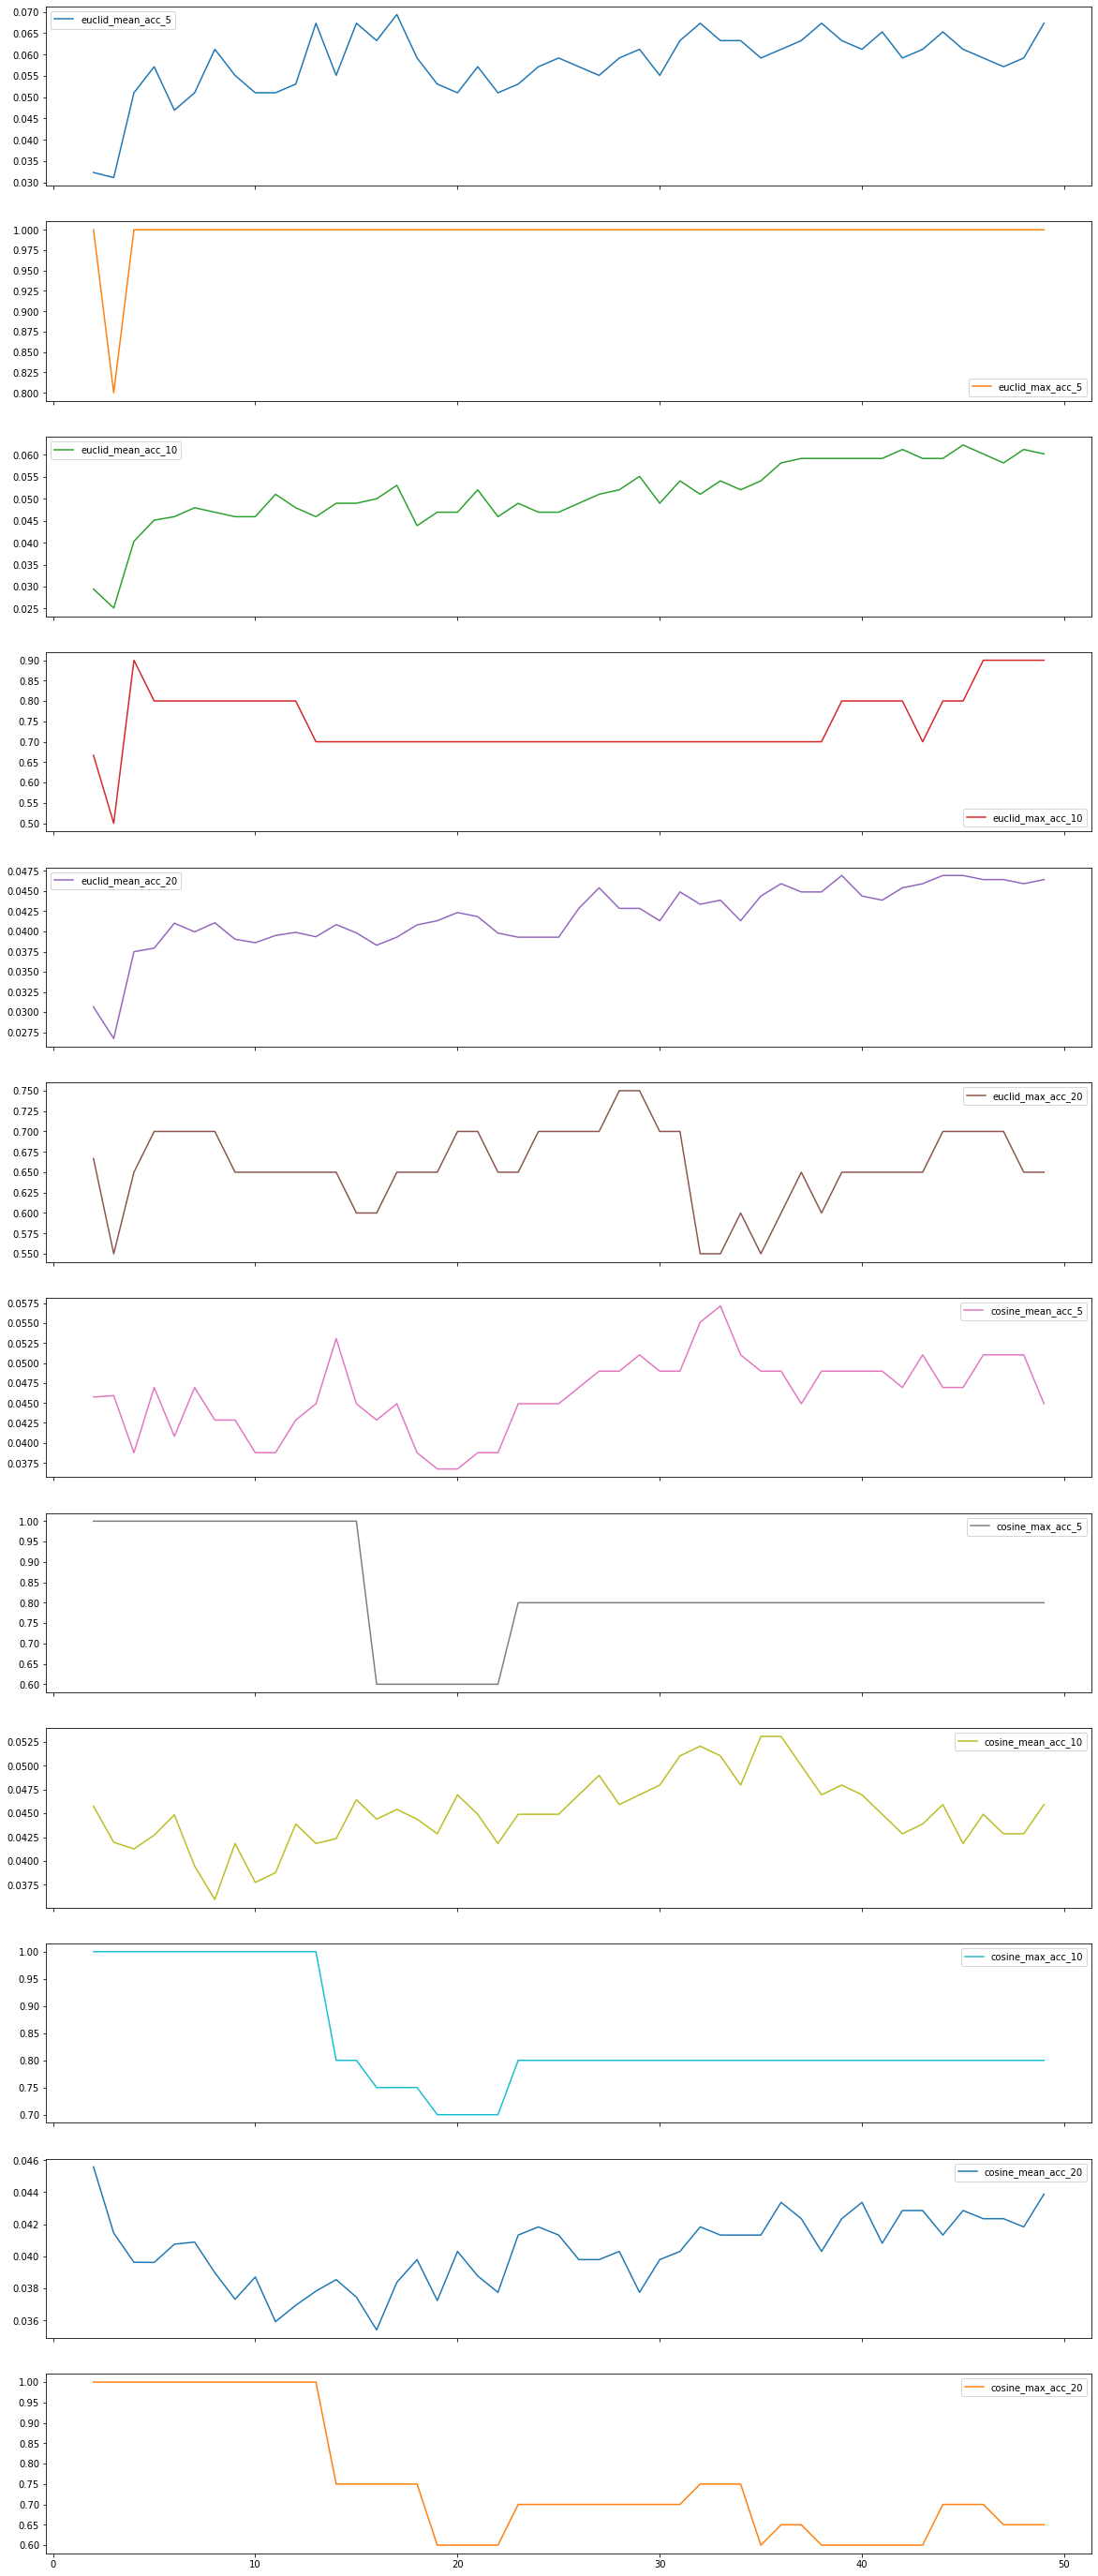

In [543]:
# теперь, варьируя разные параметры (в первую очередь число соседей и метрику), найдем где достигается максимум метрик
k_s = [5,10,20]
results_euclid = pd.DataFrame(columns = [f'euclid_mean_acc_{k_s[0]}', f'euclid_max_acc_{k_s[0]}', f'euclid_mean_acc_{k_s[1]}', f'euclid_max_acc_{k_s[1]}', f'euclid_mean_acc_{k_s[2]}', f'euclid_max_acc_{k_s[2]}'])
results_cosine = pd.DataFrame(columns = [f'cosine_mean_acc_{k_s[0]}', f'cosine_max_acc_{k_s[0]}',f'cosine_mean_acc_{k_s[1]}', f'cosine_max_acc_{k_s[1]}',f'cosine_mean_acc_{k_s[2]}', f'cosine_max_acc_{k_s[2]}'])
for metric in ['euclid', 'cosine']:
    for k in tqdm(range(2,50), leave = True):
        user_dict = recommend_NN(user_item_old_cut,user_item_diff.index, metric = metric, k = k)
        if metric == 'euclid':
            a = precision_at_k(user_item_diff, user_dict, k_s[0]), \
                precision_at_k(user_item_diff, user_dict, k_s[1]), \
                precision_at_k(user_item_diff, user_dict, k_s[2])
            
            results_euclid.loc[k] = [i for sub in a for i in sub]
        if metric == 'cosine':
            a = precision_at_k(user_item_diff, user_dict, k_s[0]), \
                precision_at_k(user_item_diff, user_dict, k_s[1]), \
                precision_at_k(user_item_diff, user_dict, k_s[2])
            
            results_cosine.loc[k] = [i for sub in a for i in sub]
results = results_euclid.join(results_cosine)
results.plot(subplots = True, figsize = (20,50))

(<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>)

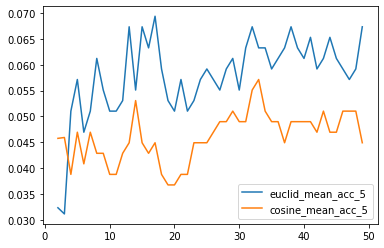

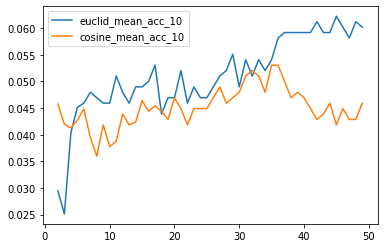

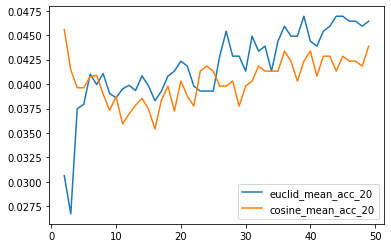

In [551]:
results.iloc[:,[0,6]].plot(), results.iloc[:,[2,8]].plot(), results.iloc[:,[4,10]].plot()

In [599]:
k_s = [5,10,20]
results_faiss = pd.DataFrame(columns = [f'faiss_mean_acc_{k_s[0]}', f'faiss_max_acc_{k_s[0]}', f'faiss_mean_acc_{k_s[1]}', f'faiss_max_acc_{k_s[1]}', f'faiss_mean_acc_{k_s[2]}', f'faiss_max_acc_{k_s[2]}'])
# results_hardcode = pd.DataFrame(columns = [f'hardcode_mean_acc_{k_s[0]}', f'hardcode_max_acc_{k_s[0]}',f'hardcode_mean_acc_{k_s[1]}', f'hardcode_max_acc_{k_s[1]}',f'hardcode_mean_acc_{k_s[2]}', f'hardcode_max_acc_{k_s[2]}'])

for method in ['faiss']:
    for k in tqdm([5,10,15], leave = True):
        user_dict = recommend_NN(user_item_old_cut,user_item_diff.index, metric = metric, k = k, method=method)
        if method == 'hardcode':
            a = precision_at_k(user_item_diff, user_dict, k_s[0]), \
                precision_at_k(user_item_diff, user_dict, k_s[1]), \
                precision_at_k(user_item_diff, user_dict, k_s[2])
            
            results_hardcode.loc[k] = [i for sub in a for i in sub]
        if method == 'faiss':
            a = precision_at_k(user_item_diff, user_dict, k_s[0]), \
                precision_at_k(user_item_diff, user_dict, k_s[1]), \
                precision_at_k(user_item_diff, user_dict, k_s[2])
            
            results_faiss.loc[k] = [i for sub in a for i in sub]
results_1 = results_hardcode.join(results_faiss)

100%|█████████████████████████████████████████████| 3/3 [00:22<00:00,  7.49s/it]


(<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>)

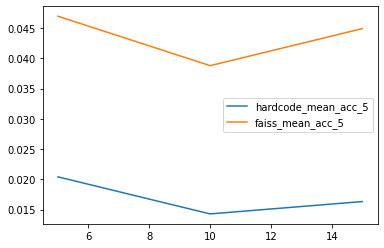

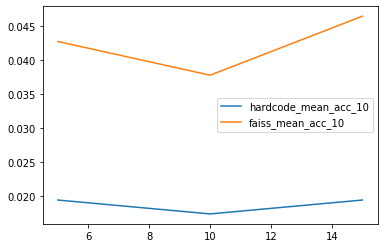

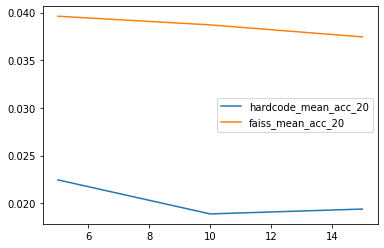

In [601]:
results_1.iloc[:,[0,6]].plot(), results_1.iloc[:,[2,8]].plot(), results_1.iloc[:,[4,10]].plot()

In [603]:
k_s = [5,10,20]
results_faiss = pd.DataFrame(columns = [f'faiss_mean_acc_{k_s[0]}', f'faiss_max_acc_{k_s[0]}', f'faiss_mean_acc_{k_s[1]}', f'faiss_max_acc_{k_s[1]}', f'faiss_mean_acc_{k_s[2]}', f'faiss_max_acc_{k_s[2]}'])
results_hardcode = pd.DataFrame(columns = [f'hardcode_mean_acc_{k_s[0]}', f'hardcode_max_acc_{k_s[0]}',f'hardcode_mean_acc_{k_s[1]}', f'hardcode_max_acc_{k_s[1]}',f'hardcode_mean_acc_{k_s[2]}', f'hardcode_max_acc_{k_s[2]}'])
metric = 'euclid'
for method in ['hardcode','faiss']:
    for k in tqdm([5,10,15], leave = True):
        user_dict = recommend_NN(user_item_old_cut,user_item_diff.index, metric = metric, k = k, method=method)
        if method == 'hardcode':
            a = precision_at_k(user_item_diff, user_dict, k_s[0]), \
                precision_at_k(user_item_diff, user_dict, k_s[1]), \
                precision_at_k(user_item_diff, user_dict, k_s[2])
            
            results_hardcode.loc[k] = [i for sub in a for i in sub]
        if method == 'faiss':
            a = precision_at_k(user_item_diff, user_dict, k_s[0]), \
                precision_at_k(user_item_diff, user_dict, k_s[1]), \
                precision_at_k(user_item_diff, user_dict, k_s[2])
            
            results_faiss.loc[k] = [i for sub in a for i in sub]
results_2 = results_hardcode.join(results_faiss)

100%|█████████████████████████████████████████████| 3/3 [00:12<00:00,  4.09s/it]


(<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>)

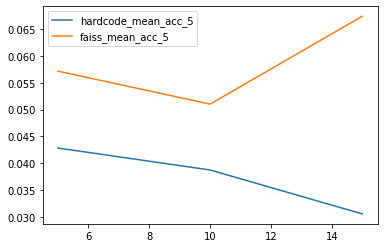

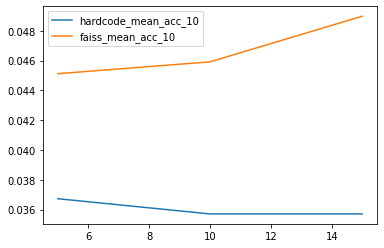

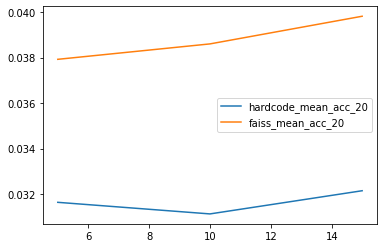

In [605]:
results_2.iloc[:,[0,6]].plot(), results_2.iloc[:,[2,8]].plot(), results_2.iloc[:,[4,10]].plot()

In [ ]:
# метрики: процент попавших из предложенных категорий по сравнению с добавившимися по факту на максимум
# и расстояние от вектора предложенных до фактических на минимум

In [ ]:
# написать цикл который бы создавал новый датафрейм с предсказанными значениями (каждому чуваку сопоставить строчку mean)
# если сравнивать не с тем же челом во времени, то относительно чего мерить точность?
# сравнивать будем с той же матрицей недельной давности по людям у которых вектора изменились чуть-чуть

## кусок с implicit модельками

In [184]:
csr_matrix(user_item_array)

<2410x576 sparse matrix of type '<class 'numpy.float32'>'
	with 22914 stored elements in Compressed Sparse Row format>

In [185]:
als_model = implicit.als.AlternatingLeastSquares(factors = 50)
als_model.fit(csr_matrix(user_item_array))

  0%|          | 0/15 [00:00<?, ?it/s]

In [210]:
sim_users = [i[0] for i in als_model.similar_users(0)]
sim_users

[0, 549, 412, 150, 393, 180, 205, 414, 517, 35]

## дальше ненужный кусок с корреляциями

In [24]:
item_corrs = np.corrcoef(item_user)

In [26]:
item_corrs_df = pd.DataFrame(item_corrs, index=item_user.index, columns=item_user.index)
item_corrs_df

,"(1017 ALYX 9SM, Футболки и лонгсливы)","(10sei0otto, Джемперы и свитеры)","(11 By Boris Bidjan Saberi, Футболки и лонгсливы)","(11 By Boris Bidjan Saberi, Штаны и брюки)","(424 On Fairfax, Куртки и пуховики)","(99%Is, Штаны и брюки)","(A Cold Wall, Пальто и плащи)","(A Cold Wall, Футболки и лонгсливы)","(A.P.C., Деним)","(A1923, Ботинки и сапоги)",...,"(Ys (Yamamoto), Пиджаки и жилеты)","(Ys (Yamamoto), Рубашки)","(Ys (Yamamoto), Футболки и лонгсливы)","(Ys (Yamamoto), Штаны и брюки)","(Yves Saint Laurent, Галстуки, запонки, носки)","(Yves Saint Laurent, Куртки и пуховики)","(Zegna Couture, Футболки и лонгсливы)","(Ziggy Chen, Штаны и брюки)","(kaval, Штаны и брюки)","(ВЛАД ВЫСОЦКИЙ, Украшения и другое)"
"(1017 ALYX 9SM, Футболки и лонгсливы)",1.000000,-0.000132,-0.000426,0.003863,-0.000208,-0.000465,0.017268,0.270277,0.011872,-0.000402,...,-0.000648,0.043212,-0.000365,-0.000497,-0.000412,-0.000825,-0.000132,-0.000535,-0.000339,0.005634
"(10sei0otto, Джемперы и свитеры)",-0.000132,1.000000,-0.000094,-0.000108,-0.000046,-0.000103,-0.000336,-0.000228,-0.000091,-0.000089,...,-0.000143,-0.000132,-0.000081,-0.000110,-0.000091,-0.000182,-0.000029,-0.000118,-0.000075,-0.000404
"(11 By Boris Bidjan Saberi, Футболки и лонгсливы)",-0.000426,-0.000094,1.000000,0.012087,0.102170,-0.000332,0.023961,-0.000737,-0.000296,-0.000287,...,0.009187,0.010002,-0.000261,0.009332,-0.000294,-0.000589,-0.000094,0.088735,-0.000242,0.020017
"(11 By Boris Bidjan Saberi, Штаны и брюки)",0.003863,-0.000108,0.012087,1.000000,-0.000171,0.014698,0.031908,0.036820,-0.000341,-0.000331,...,0.037301,-0.000493,0.026356,0.003044,-0.000339,0.051250,-0.000108,-0.000440,-0.000279,0.009894
"(424 On Fairfax, Куртки и пуховики)",-0.000208,-0.000046,0.102170,-0.000171,1.000000,-0.000162,0.009961,-0.000360,-0.000145,-0.000140,...,-0.000226,-0.000209,-0.000127,-0.000173,-0.000144,-0.000288,-0.000046,0.021589,-0.000118,-0.000639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(Yves Saint Laurent, Куртки и пуховики)",-0.000825,-0.000182,-0.000589,0.051250,-0.000288,-0.000643,0.006612,0.016958,-0.000573,-0.000556,...,0.002461,-0.000828,-0.000505,0.019536,-0.000570,1.000000,-0.000182,-0.000740,-0.000468,0.019726
"(Zegna Couture, Футболки и лонгсливы)",-0.000132,-0.000029,-0.000094,-0.000108,-0.000046,-0.000103,-0.000336,-0.000228,-0.000091,-0.000089,...,-0.000143,-0.000132,-0.000081,-0.000110,-0.000091,-0.000182,1.000000,-0.000118,-0.000075,0.065505
"(Ziggy Chen, Штаны и брюки)",-0.000535,-0.000118,0.088735,-0.000440,0.021589,0.013090,0.003206,0.002823,-0.000371,-0.000361,...,0.128803,0.012781,-0.000327,-0.000445,-0.000370,-0.000740,-0.000118,1.000000,0.066099,0.000627
"(kaval, Штаны и брюки)",-0.000339,-0.000075,-0.000242,-0.000279,-0.000118,-0.000264,0.016201,0.020414,0.027661,-0.000228,...,0.333258,0.049395,-0.000207,0.022816,-0.000234,-0.000468,-0.000075,0.066099,1.000000,-0.001039


In [4]:
user_item = pref_matrix.drop(columns=['id_s','item_total'], index = ['user_total']).T
user_item

,"(1017 ALYX 9SM, Футболки и лонгсливы)","(10sei0otto, Джемперы и свитеры)","(11 By Boris Bidjan Saberi, Футболки и лонгсливы)","(11 By Boris Bidjan Saberi, Штаны и брюки)","(424 On Fairfax, Куртки и пуховики)","(99%Is, Штаны и брюки)","(A Cold Wall, Пальто и плащи)","(A Cold Wall, Футболки и лонгсливы)","(A.P.C., Деним)","(A1923, Ботинки и сапоги)",...,"(Ys (Yamamoto), Пиджаки и жилеты)","(Ys (Yamamoto), Рубашки)","(Ys (Yamamoto), Футболки и лонгсливы)","(Ys (Yamamoto), Штаны и брюки)","(Yves Saint Laurent, Галстуки, запонки, носки)","(Yves Saint Laurent, Куртки и пуховики)","(Zegna Couture, Футболки и лонгсливы)","(Ziggy Chen, Штаны и брюки)","(kaval, Штаны и брюки)","(ВЛАД ВЫСОЦКИЙ, Украшения и другое)"
1586517765142996502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1586839436824718143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1586861088574635654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1586877094630823534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1587480513689496288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640668414990247385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1640817089200208316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1642171750651415285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1642196883929739524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
user1 = user_item.loc['1586517765142996502']
user2 = user_item.loc['1587480513689496288']
np.corrcoef(user1, user2)[0][1]

-0.005406218054745005

In [149]:
corrs

array([[ 1.        , -0.00884118, -0.00765223, ..., -0.00765223,
                nan,  0.02320118],
       [-0.00884118,  1.        , -0.00403977, ..., -0.00403977,
                nan, -0.01372663],
       [-0.00765223, -0.00403977,  1.        , ..., -0.0034965 ,
                nan, -0.01188068],
       ...,
       [-0.00765223, -0.00403977, -0.0034965 , ...,  1.        ,
                nan, -0.01188068],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.02320118, -0.01372663, -0.01188068, ..., -0.01188068,
                nan,  1.        ]])

In [15]:
corrs = np.corrcoef(user_item)


In [150]:
corrs_df = pd.DataFrame(corrs)

In [151]:
corrs_df

,0,1,2,3,4,5,6,7,8,9,...,34400,34401,34402,34403,34404,34405,34406,34407,34408,34409
0,1.000000,-0.008841,-0.007652,-0.008159,-0.005406,NaN,0.084935,0.054270,-0.016080,NaN,...,-0.005406,-0.005406,-0.005406,NaN,NaN,0.054270,-0.005406,-0.007652,NaN,0.023201
1,-0.008841,1.000000,-0.004040,-0.004307,-0.002854,NaN,-0.009070,-0.002854,-0.008489,NaN,...,-0.002854,-0.002854,-0.002854,NaN,NaN,-0.002854,-0.002854,-0.004040,NaN,-0.013727
2,-0.007652,-0.004040,1.000000,-0.003728,-0.002470,NaN,-0.007850,-0.002470,-0.007347,NaN,...,-0.002470,-0.002470,-0.002470,NaN,NaN,-0.002470,-0.002470,-0.003497,NaN,-0.011881
3,-0.008159,-0.004307,-0.003728,1.000000,-0.002634,NaN,0.213376,-0.002634,-0.007834,NaN,...,-0.002634,-0.002634,-0.002634,NaN,NaN,-0.002634,-0.002634,-0.003728,NaN,0.111984
4,-0.005406,-0.002854,-0.002470,-0.002634,1.000000,NaN,-0.005546,-0.001745,-0.005191,NaN,...,-0.001745,-0.001745,-0.001745,NaN,NaN,-0.001745,-0.001745,-0.002470,NaN,-0.008394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34405,0.054270,-0.002854,-0.002470,-0.002634,-0.001745,NaN,-0.005546,-0.001745,-0.005191,NaN,...,-0.001745,-0.001745,-0.001745,NaN,NaN,1.000000,-0.001745,-0.002470,NaN,-0.008394
34406,-0.005406,-0.002854,-0.002470,-0.002634,-0.001745,NaN,-0.005546,-0.001745,-0.005191,NaN,...,-0.001745,-0.001745,-0.001745,NaN,NaN,-0.001745,1.000000,-0.002470,NaN,-0.008394
34407,-0.007652,-0.004040,-0.003497,-0.003728,-0.002470,NaN,-0.007850,-0.002470,-0.007347,NaN,...,-0.002470,-0.002470,-0.002470,NaN,NaN,-0.002470,-0.002470,1.000000,NaN,-0.011881
34408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
corrs_df[1].isna().sum() == corrs_df.shape[0]

False

In [112]:
recommended = {}
for user in user_item.index:
    recommended[user] = {}

rec_items = 10
similar_users = 60
# среднее вместо сумм считать

for user in recommended:
    
    # тут отбираем для рек пользователя n похожих на него
    similar_users = corrs_df.loc[user].drop(user).nlargest(sim_users)

    # берем что смотрели похожие челы и складываем предпочтения
    similar_prefs = user_item.loc[similar_users.index]
    similar_prefs.loc['item_sum'] = similar_prefs.sum(axis = 0)

    # берем самые предпочтительные категории
    top_items = similar_prefs.T.sort_values('item_sum', ascending = False)
    
    # тут оставляю только те бренды-категории, в которых не отметился юзер, для которого рекомендуем
#     outer_recs = top_items.loc[
#         ~top_items.index.isin(item_user.loc[item_user[user] > 0].index)]['item_sum'].head(rec_items).to_dict()

    # тут оставляем, только при рекомендации конкретных штрихкодов, надо будет выкинуть те, где чел смотрел
    all_recs = top_items['item_sum'].head(rec_items).to_dict()
    
    recommended[user] = all_recs
#     break

In [113]:
recommended

{'1586517765142996502': {('Dolce & Gabbana', 'Куртки и пуховики'): 83.0,
  ('Stone Island', 'Свитшоты и худи'): 11.0,
  ('Giorgio Brato', 'Куртки и пуховики'): 1.0,
  ('Visvim', 'Свитшоты и худи'): 1.0,
  ('Ralph Lauren', 'Куртки и пуховики'): 1.0,
  ('Prada', 'Головные уборы'): 0.0,
  ('Paul Harnden Shoemakers', 'Пиджаки и жилеты'): 0.0,
  ('Paul Harnden Shoemakers', 'Рубашки'): 0.0,
  ('Pierre Balmain', 'Пальто и плащи'): 0.0,
  ('Pierre Balmain', 'Футболки и лонгсливы'): 0.0},
 '1586839436824718143': {('Archvio J.M. Ribot', 'Пиджаки и жилеты'): 69.0,
  ('Paul Harnden Shoemakers', 'Пиджаки и жилеты'): 66.0,
  ('Greg Lauren', 'Штаны и брюки'): 4.0,
  ('Paul Harnden Shoemakers', 'Рубашки'): 3.0,
  ('Saint Laurent Paris', 'Ремни'): 3.0,
  ('Maison Margiela', 'Пиджаки и жилеты'): 2.0,
  ('Boris Bidjan Saberi', 'Туфли'): 2.0,
  ('Vivienne Westwood', 'Пиджаки и жилеты'): 2.0,
  ('Carol Christian Poell', 'Рубашки'): 2.0,
  ('Isaac Sellam Experience', 'Кожаные куртки'): 2.0},
 '1586861088574

In [123]:
# проверяю заполненность предложенных
filling_by_user = {}

for user, recs in recommended.items():
    filling_by_user[user] = 0
    for rec, value in recs.items():
        if value > 0:
            filling_by_user[user] += 1/len(recs)
    filling_by_user[user] = round(filling_by_user[user],1)

<AxesSubplot:ylabel='Frequency'>

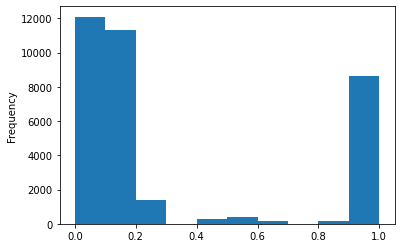

In [145]:
# распределение процентов заполненности
pd.Series(filling_by_user).plot(kind = 'hist', bins = 10)

In [164]:
# сколько людей с абсолютно никакими сходствами
null_rows = 0
for row in corrs_df:
    if corrs_df[row].isna().sum() == corrs_df.shape[0]:
        null_rows += 1
null_rows

12094

In [ ]:
# выкинуть всех пустых чуваков (или меньше какого-то колва оценок (параметром))
# пробовать косинусную кор-ю
# либо смотреть чтобы похожесть считалась (модуль implicit и др), по безнулевым элементам юзеров
# если нету то закодить 
# параметры: сколько похожих людей и какую степень похожести брать и их варьируем для оптимальности (возможно гибкие)
# делим выборку клиентов на трейн (тут подбор параметров выше) тест
# или разделить по времени людей на подвыборки (в пн идет в трейн, в вт в тест)

# по таргетам смотреть конверсии/увеличения по просмотрам


In [ ]:
# попробовать захардкодить поиск соседей без нулей
# причесать в срц
# зафиксить метрики (пресижн эт 5/10/30 зависит от того сколько показываем товаров чтобы не менялся знаменатель)
# запихнуть всех людей в валидацию, только сменит абс значения метрики
# подвигать окна
# пакет flask


In [ ]:
# для челов из валидации искать соседей только из трейна!!!
# закодил recall at k (сколько таргетов есть в предсказаниях)
# надо переделать чтобы искало сколько из предсказанных есть в таргете
# закодить их отдельными функциями для отдельных чуваков
# пересмотр графиков
# через фласк законнектить нулевую модельку (рандомайзер) 
# возможно про докер надо почитать на будущее